# Airfoil ML Regression Project

Predicting lift ($C_l$) and drag ($C_d$) coefficients from airfoil geometry and flow parameters.

---

**Inputs:**
- Camber
- Camber Position
- Thickness
- Thickness Position
- Chord Length
- Angle of Attack (AoA)
- Reynolds Number (Re)

**Outputs:**
- Lift Coefficient ($C_l$)
- Drag Coefficient ($C_d$)

---

*This notebook is structured for learning and future extension. Each section is commented and explained.*

## 1. Imports & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
sns.set(style="whitegrid")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")

In [4]:
import jupyterlab
print(jupyterlab.__version__)

4.4.5


/Users/stellawagner/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
data = pd.read_csv("../data/airfoil_dataset.csv")
data.head()

,Name,camber (%),camber_pos (%),thickness (%),thickness_pos (%),chord_length,reynolds_number,angle_of_attack (deg),lift_coefficent,drag_coefficent,max_efficency (Cl/Cd),max_efficency_aoa (deg)
0,NACA 0006,0.0,0.0,6.0,30.0,1.0,"50,000",-8.25,-0.6744,0.10463,24.9,3.5
1,NaN,0.0,0.0,6.0,30.0,1.0,"50,000",-8.00,-0.6770,0.10152,NaN,NaN
2,NaN,0.0,0.0,6.0,30.0,1.0,"50,000",-7.75,-0.6873,0.09891,NaN,NaN
3,NaN,0.0,0.0,6.0,30.0,1.0,"50,000",-7.50,-0.6648,0.09391,NaN,NaN
4,NaN,0.0,0.0,6.0,30.0,1.0,"50,000",-7.00,-0.6541,0.08634,NaN,NaN


In [6]:
data['Name'] = data['Name'].ffill()
data = data.dropna(how='all') 
data['reynolds_number'] = data['reynolds_number'].replace(',', '', regex=True).astype(float)
data['Name'] = data['Name'].astype('category')

In [7]:
print(data.isnull().sum())

Name                           0
camber (%)                   148
camber_pos (%)               148
thickness (%)                148
thickness_pos (%)            148
chord_length                 148
reynolds_number              148
angle_of_attack (deg)        148
lift_coefficent              148
drag_coefficent              148
max_efficency (Cl/Cd)      16748
max_efficency_aoa (deg)    16746
dtype: int64


In [8]:
print(data.shape)
print(data.describe())

(16896, 12)
         camber (%)  camber_pos (%)  thickness (%)  thickness_pos (%)  \
count  16748.000000    16748.000000   16748.000000       16748.000000   
mean       1.412193       20.460754      14.370074          29.879365   
std        1.232996       17.783047       4.873783           0.302069   
min        0.000000        0.000000       6.000000          29.300000   
25%        0.000000        0.000000      11.000000          29.500000   
50%        1.800000       15.000000      12.000000          30.000000   
75%        2.000000       40.000000      18.000000          30.000000   
max        6.000000       50.000000      24.000000          30.900000   

       chord_length  reynolds_number  angle_of_attack (deg)  lift_coefficent  \
count       16748.0     16748.000000           16748.000000     16748.000000   
mean            1.0    421892.166229               0.955995         0.191155   
std             0.0    361941.179480               9.138886         0.837980   
min       

In [9]:
print(data['Name'].unique())

['NACA 0006', 'NACA 0009', 'NACA 0012', 'NACA 2414', 'NACA 2415', ..., 'NACA 23021', 'NACA 23024', 'NACA 23112', 'NACA 24112', 'NACA 25112']
Length: 30
Categories (30, object): ['NACA 0006', 'NACA 0008', 'NACA 0009', 'NACA 0010', ..., 'NACA 2418', 'NACA 2421', 'NACA 25112', 'NACA 6409']


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


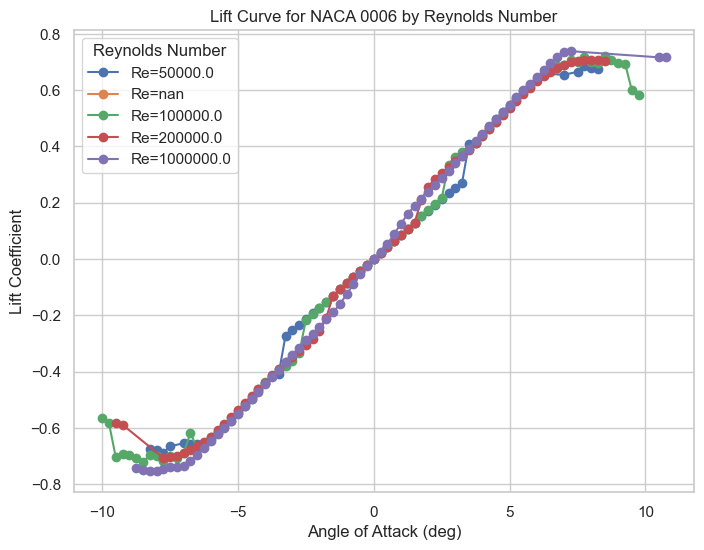

In [27]:
import matplotlib.pyplot as plt

airfoil = "NACA 0006"  # example, change as needed
subset = data[data['Name'] == airfoil]

# Get all unique Reynolds numbers for this airfoil
reynolds_numbers = subset['reynolds_number'].unique()

plt.figure(figsize=(8, 6))

for reynolds in reynolds_numbers:
    sub = subset[subset['reynolds_number'] == reynolds]
    plt.plot(sub['angle_of_attack (deg)'], sub['lift_coefficent'], marker='o', label=f'Re={reynolds}')

plt.xlabel('Angle of Attack (deg)')
plt.ylabel('Lift Coefficient')
plt.title(f'Lift Curve for {airfoil} by Reynolds Number')
plt.legend(title="Reynolds Number")
plt.show()

In [11]:
feature_cols = [
    'camber (%)',
    'camber_pos (%)',
    'thickness (%)',
    'thickness_pos (%)',
    'chord_length',
    'angle_of_attack (deg)',
    'reynolds_number',
    # 'Name', # Uncomment if want to use airfoil name as a feature
]

# If you want to use 'Name', encode it numerically:
# data['Name_code'] = data['Name'].cat.codes
# feature_cols.append('Name_code')

X = data[feature_cols]
y = data[['lift_coefficent', 'drag_coefficent']]

In [12]:
# Remove rows where either target is missing
data_clean = data.dropna(subset=['lift_coefficent', 'drag_coefficent'])

# Redefine X and y using the cleaned data
X = data_clean[feature_cols]
y = data_clean[['lift_coefficent', 'drag_coefficent']]

## Random Forest Regressor 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [15]:
# Example: Predict for a new set of geometric parameters
new_params = pd.DataFrame({
    'camber (%)': [2.0],
    'camber_pos (%)': [40.0],
    'thickness (%)': [12.0],
    'thickness_pos (%)': [30.0],
    'chord_length': [1.0],
    'angle_of_attack (deg)': [2.0],
    'reynolds_number': [100000],
    # 'Name_code': [data['Name'].cat.categories.get_loc('NACA 2412')], # If using name
})

pred = model.predict(new_params)
print("Predicted lift coefficient:", pred[0][0])
print("Predicted drag coefficient:", pred[0][1])

Predicted lift coefficient: 0.5213180000000004
Predicted drag coefficient: 0.015103299999999997


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.9800536034428001
MSE: 0.0006871187696940756


## Gradient Boosting Regressor 


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

In [19]:
# X = data_clean[feature_cols]
# y = data_clean[['lift_coefficent', 'drag_coefficent']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
# Train for lift coefficient
gb_lift = GradientBoostingRegressor()
gb_lift.fit(X_train, y_train['lift_coefficent'])

# Train for drag coefficient
gb_drag = GradientBoostingRegressor()
gb_drag.fit(X_train, y_train['drag_coefficent'])

GradientBoostingRegressor()

In [21]:
# Predict and score lift
lift_pred = gb_lift.predict(X_test)
print("Lift R2:", gb_lift.score(X_test, y_test['lift_coefficent']))

# Predict and score drag
drag_pred = gb_drag.predict(X_test)
print("Drag R2:", gb_drag.score(X_test, y_test['drag_coefficent']))

Lift R2: 0.9880898962092314
Drag R2: 0.864383496725933


In [22]:
# Example: Predict for new airfoil parameters
new_params = pd.DataFrame({
    'camber (%)': [2.0],
    'camber_pos (%)': [40.0],
    'thickness (%)': [12.0],
    'thickness_pos (%)': [30.0],
    'chord_length': [1.0],
    'angle_of_attack (deg)': [2.0],
    'reynolds_number': [100000],
})

lift_new = gb_lift.predict(new_params)
drag_new = gb_drag.predict(new_params)
print("Predicted lift coefficient:", lift_new[0])
print("Predicted drag coefficient:", drag_new[0])

Predicted lift coefficient: 0.47181970073303087
Predicted drag coefficient: 0.018300298596698183


In [23]:
mse_lift = mean_squared_error(y_test['lift_coefficent'], lift_pred)
mse_drag = mean_squared_error(y_test['drag_coefficent'], drag_pred)
print("Lift MSE:", mse_lift)
print("Drag MSE:", mse_drag)

Lift MSE: 0.00824303624429193
Drag MSE: 7.570452484610465e-05


In [24]:
rmse_lift = np.sqrt(mse_lift)
rmse_drag = np.sqrt(mse_drag)
print("Lift RMSE:", rmse_lift)
print("Drag RMSE:", rmse_drag)

Lift RMSE: 0.09079116831659305
Drag RMSE: 0.008700834721226732


### Tuning Hyperparameters

In [25]:
gb_lift = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
gb_lift.fit(X_train, y_train['lift_coefficent'])

GradientBoostingRegressor(max_depth=4, n_estimators=500, random_state=42)

In [26]:
new_params = pd.DataFrame({
    'camber (%)': [2.0],
    'camber_pos (%)': [40.0],
    'thickness (%)': [12.0],
    'thickness_pos (%)': [30.0],
    'chord_length': [1.0],
    'angle_of_attack (deg)': [2.0],
    'reynolds_number': [100000],
})

lift_new = gb_lift.predict(new_params)
drag_new = gb_drag.predict(new_params)
print("Predicted lift coefficient:", lift_new[0])
print("Predicted drag coefficient:", drag_new[0])

Predicted lift coefficient: 0.4988533320328786
Predicted drag coefficient: 0.018300298596698183
